In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_seq2seq_data_provider import PriceHistorySeq2SeqDataProvider
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
#from models.price_history_21_seq2seq_dyn_dec_ins import PriceHistorySeq2SeqDynDecIns
from data_providers.PriceHistoryMobileAttrsCombinator import PriceHistoryMobileAttrsCombinator
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
from data_providers.price_hist_with_relevant_deals import PriceHistWithRelevantDeals

import operator

/home/student/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [4]:
input_len = 60
target_len = 30
with_EOS = False
kmeans_group = 10

In [5]:
#reading from
data_path = '../../../../Dropbox/data'
mobattrs_ph_path = data_path + '/mobattrs_price_history'
mobattrs_ph_norm_path = mobattrs_ph_path + '/mobattrs_ph_norm.npy'
sku_ids_groups_path = data_path + '/sku_ids_groups'
npz_sku_ids_group_kmeans = sku_ids_groups_path + '/sku_ids_kmeans_{:02d}.npz'.format(kmeans_group)

price_history_csv = "../price_history_03_seq_start_suddens_trimmed.csv"

mobiles_path = data_path + '/mobiles'
mobs_norm_path = mobiles_path + '/mobiles_norm.csv'

In [6]:
sku_id_groups = np.load(npz_sku_ids_group_kmeans)
cur_zip = zip(sku_id_groups.items(), [item[1].shape for item in sku_id_groups.items()])
sorted_groups = OrderedDict([item[0] for item in sorted(cur_zip, key=operator.itemgetter(1))])

In [7]:
for key, val in sorted_groups.iteritems():
    print key, ",", val.shape

2 , (3,)
6 , (24,)
4 , (32,)
0 , (50,)
1 , (57,)
7 , (79,)
8 , (79,)
5 , (102,)
3 , (109,)
9 , (154,)


In [8]:
from data_providers.data_gen_38 import DatasetGenerator

In [9]:
dg = DatasetGenerator(npz_sku_ids_group_kmeans=npz_sku_ids_group_kmeans,
                     price_history_csv=price_history_csv,
                     input_min_len = input_len,
                     target_len=target_len,
                     random_state=random_state)

In [10]:
aa, bb, cc = dg.prepare(chosen_cluster=9)

[ 7653378  8874019  9500739  7219275  9501836  7321695  8435811  7335955
 10766459  9724038  9132174 10252434 10741925  7423345 10350760  9633962
  8437937  6260915  9889976 10619076 10909904 10922201  5535970  7620866
  9445080  9820435  8116861  7282995  9550139  6957383  9105758  3656048
 10430833 10456126  9130370 10603460  9898380 10830222  9402788  7723431
  9107905  7621093 10922474 10620599  8012281  5804541  7508833 10117891
 10922517  6918686  9259567  7621172 10822203  6808160 10955366 10922599
 10705514 10822252  8460398  9216668  8395434  9419455 10822358 10742492
  8286967 10670840  9173758  9669402  8735524  9188134  9333571 10627915
 10468270  9758209  8770390 10802015  8436609 10902417 10627992  9669553
 10020902  6808527  8985553  7357394  8758228  6044652 10263538  3136502
  8082430 11002883 10001441 10019886  9655436 10251789 10569851  7904356
  8244331  9759446  8176770  9192579  7259273 10296471  9562308 10019997
  9542492  6601918  9198786  9757914  9473245 10550

In [14]:
# instead of keeping the series, simply find the first threshold (train vs valid and test)
# and then return the second threshold (train + valid vs test)

# Next step is to split the original df of the prices in three separate dfs and feed them inside the old generator
# to create training samples
# note that the valid will actually be the previous 60 days of data and forecasting to valid
# the test will be the previous 60 days of data and forecasting to test
# In other words we will have overlaps to create the validation set and the testing set

# In addition the training dataset for the final model will be consisted of both the train and valid span of data
# So this means a fourth dataframe should be generated

In [12]:
type(aa[0])

pandas.core.series.Series

# Actual Run

In [83]:
data_path = '../../../../Dropbox/data'
ph_data_path = data_path + '/price_history'
assert path.isdir(ph_data_path)

In [84]:
npz_full = ph_data_path + '/price_history_per_mobile_phone.npz'

In [85]:
dataset_gen = PriceHistoryDatasetPerMobilePhone(random_state=random_state)

In [86]:
dic = dataset_gen.genSaveDictionary(csv_in=csv_in, window_len=90, npz_out=npz_full)
dic.keys()

['9820435',
 '8332719',
 '7357394',
 '9351583',
 '8012281',
 '7655259',
 '6253594',
 '8138004',
 '10576161',
 '7408246',
 '7967487',
 '9130370',
 '8779166',
 '7653378',
 '10536998',
 '8669008',
 '9896674',
 '9941958',
 '7321695',
 '10499793',
 '9259167',
 '8221632',
 '9986194',
 '9898913',
 '10129132',
 '9055991',
 '10327862',
 '7364333',
 '8176770',
 '7507905',
 '3656048',
 '10112367',
 '8695009',
 '8735993',
 '10242128',
 '8648639',
 '8414311',
 '9875453',
 '7508833',
 '9426447',
 '6261140',
 '7294741',
 '9674179',
 '9064268',
 '7321837',
 '10409332',
 '10020902',
 '10002261',
 '6870822',
 '7351792',
 '10620877',
 '7620866',
 '9301596',
 '9981614',
 '8087014',
 '9941623',
 '5308163',
 '9469401',
 '8938578',
 '10046764',
 '10468270',
 '9035623',
 '9558425',
 '10340158',
 '7514433',
 '9758209',
 '9757914',
 '9028851',
 '10339856',
 '7509017',
 '6989466',
 '6999080',
 '10340038',
 '10242193',
 '9306016',
 '7401406',
 '8379645',
 '8379646',
 '9783218',
 '9783213',
 '9956199',
 '9268867',

# Arima

In [104]:
from arima.arima_estimator import ArimaEstimator
import warnings
from collections import OrderedDict
from mylibs.py_helper import cartesian_coord
from arima.arima_cv import ArimaCV

In [91]:
parameters = OrderedDict([
    ('p_auto_regression_order', range(6)), #0-5
    ('d_integration_level', range(3)), #0-2
    ('q_moving_average', range(6)), #0-5
])

In [93]:
cart = cartesian_coord(*parameters.values())
cart.shape

(108, 3)

In [105]:
cur_sku = dic.values()[0]
cur_sku.keys()

['test', 'train', 'train_dates']

In [110]:
full_mat = cur_sku['train']
full_mat.shape

(31, 90)

In [111]:
target_len

30

In [113]:
inputs = full_mat[:, :-target_len]
inputs.shape

(31, 60)

In [115]:
targets = full_mat[:, -target_len:]
targets.shape

(31, 30)

In [117]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ae = ArimaEstimator(p_auto_regression_order=0, d_integration_level=1, q_moving_average=0, easy_mode=True)
    ae.fit(inputs, targets).score(inputs, targets)

CPU times: user 15.4 s, sys: 53.1 s, total: 1min 8s
Wall time: 9.06 s


In [118]:
score_dic_filepath = data_path + "/arima/scoredic_testing.npy"

In [119]:
path.abspath(score_dic_filepath)

'/home/student/Dropbox/data/arima/scoredic_testing.npy'

In [121]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    scoredic = ArimaCV.cross_validate(inputs=inputs, targets=targets, cartesian_combinations=cart,
                                      score_dic_filepath=score_dic_filepath, easy_mode=True)

CPU times: user 4h 41min 23s, sys: 13h 11min 9s, total: 17h 52min 33s
Wall time: 4h 4min 51s


In [ ]:
#4h 4min 51s / 108 cases => ~= 136 seconds per case !

In [127]:
arr = np.array(list(scoredic.iteritems()))
arr.shape

(108, 2)

In [137]:
np.NaN

nan

In [146]:
import math

In [149]:
float('nan') == np.NaN

False

In [152]:
#np.isnan()
filtered_arr = arr[ np.logical_not(arr[:, 1] != arr[:, 1]) ]
filtered_arr.shape

(81, 2)

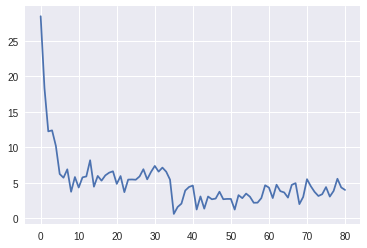

In [154]:
plt.plot(filtered_arr[:, 1])

In [156]:
minarg = np.argmin(filtered_arr[:, 1])
minarg

35

In [161]:
best_params = filtered_arr[minarg, 0]
best_params

(0, 1, 0)

In [173]:
test_mat = cur_sku['test']
test_ins = test_mat[:-target_len]
test_ins.shape

(60,)

In [171]:
test_tars = test_mat[-target_len:]
test_tars.shape

(30,)

In [174]:
test_ins_vals = test_ins.values.reshape(1, -1)
test_ins_vals.shape

(1, 60)

In [172]:
test_tars_vals = test_tars.values.reshape(1, -1)
test_tars_vals.shape

(1, 30)

# Testing with easy mode on

In [176]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ae = ArimaEstimator(p_auto_regression_order=best_params[0],
                        d_integration_level=best_params[1],
                        q_moving_average=best_params[2],
                        easy_mode=True)
    score = ae.fit(test_ins_vals, test_tars_vals).score(test_ins_vals, test_tars_vals)

CPU times: user 316 ms, sys: 1.2 s, total: 1.51 s
Wall time: 200 ms


In [179]:
score

0.0084708222952833978

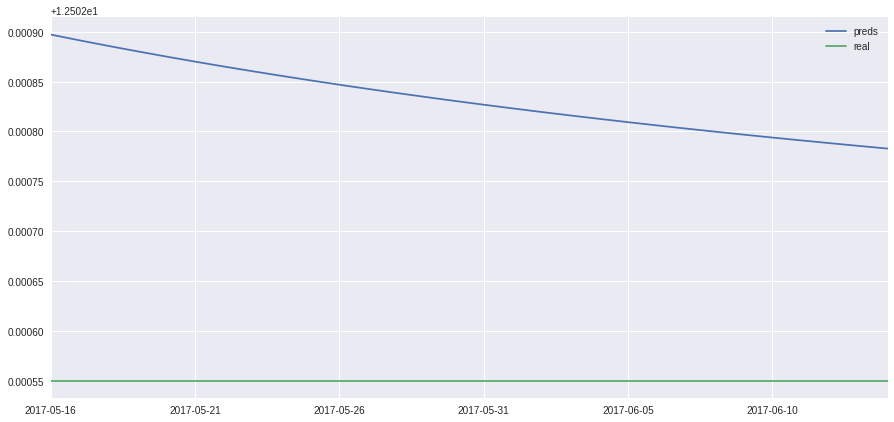

In [184]:
plt.figure(figsize=(15,7))
plt.plot(ae.preds.flatten(), label='preds')
test_tars.plot(label='real')
plt.legend()
plt.show()

# Testing with easy mode off

In [185]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ae = ArimaEstimator(p_auto_regression_order=best_params[0],
                        d_integration_level=best_params[1],
                        q_moving_average=best_params[2],
                        easy_mode=False)
    score = ae.fit(test_ins_vals, test_tars_vals).score(test_ins_vals, test_tars_vals)

CPU times: user 276 ms, sys: 956 ms, total: 1.23 s
Wall time: 203 ms


In [186]:
score

0.16127036409641349

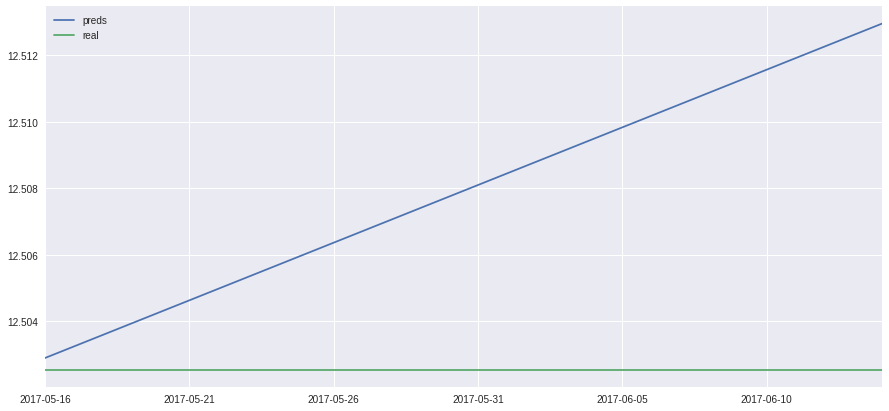

In [187]:
plt.figure(figsize=(15,7))
plt.plot(ae.preds.flatten(), label='preds')
test_tars.plot(label='real')
plt.legend()
plt.show()

#### Conclusion
If you are training in easy mode then what you get at the end is that the model only cares for the previous value in order to do its predictions and this makes it much easier for everybody but in reality we might not have advantage